In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
import wrds
db = wrds.Connection()
# Enter your credentials.
# Username: <amberchen>
# Password: <3ii6Qxrj#.C3Cjc>
# db.close()

Enter your WRDS username [DRNPRO]:nikoldy
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


## Data collection 

In [3]:
monthly_return = db.raw_sql('select caldt, crsp_fundno, mret from crsp_q_mutualfunds.monthly_returns;', date_cols=['caldt'])
monthly_return.head()

,caldt,crsp_fundno,mret
0,1997-02-28,1.00000,nan
1,1997-03-31,1.00000,-0.01179
2,1997-04-30,1.00000,0.00842
3,1997-05-30,1.00000,0.01352
4,1997-06-30,1.00000,0.01250


In [4]:
monthly_tna = db.raw_sql('select caldt, crsp_fundno, mtna from crsp_q_mutualfunds.monthly_tna;', date_cols=['caldt'])
monthly_tna.head()

,caldt,crsp_fundno,mtna
0,1997-01-31,1.00000,0.10000
1,1997-02-28,1.00000,3.92600
2,1997-03-31,1.00000,12.08100
3,1997-04-30,1.00000,20.54000
4,1997-05-30,1.00000,26.15700


In [5]:
fund_summary = db.raw_sql("select caldt, crsp_fundno, fund_name, lipper_class_name from crsp_q_mutualfunds.fund_summary2 where lipper_class_name like 'Small-Cap Value Funds';", date_cols=['caldt'])
fund_summary.head()

,caldt,crsp_fundno,fund_name,lipper_class_name
0,1999-12-31,292.00000,CitiFunds Trust II: CitiFunds Small Cap Value ...,Small-Cap Value Funds
1,2000-03-31,292.00000,CitiFunds Trust II: CitiFunds Small Cap Value ...,Small-Cap Value Funds
2,2000-06-30,292.00000,CitiFunds Trust II: CitiFunds Small Cap Value ...,Small-Cap Value Funds
3,1999-12-31,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds
4,2000-03-31,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds


In [6]:
ret_tna = pd.merge(monthly_return,monthly_tna,left_on = ['caldt','crsp_fundno'],right_on=['caldt','crsp_fundno'])
ret_tna.head()

,caldt,crsp_fundno,mret,mtna
0,1997-02-28,1.00000,nan,3.92600
1,1997-03-31,1.00000,-0.01179,12.08100
2,1997-04-30,1.00000,0.00842,20.54000
3,1997-05-30,1.00000,0.01352,26.15700
4,1997-06-30,1.00000,0.01250,34.60900


In [7]:
df = fund_summary.merge(ret_tna, how='left',on=['caldt','crsp_fundno'])
df

,caldt,crsp_fundno,fund_name,lipper_class_name,mret,mtna
0,1999-12-31,292.00000,CitiFunds Trust II: CitiFunds Small Cap Value ...,Small-Cap Value Funds,0.04604,15.10000
1,2000-03-31,292.00000,CitiFunds Trust II: CitiFunds Small Cap Value ...,Small-Cap Value Funds,0.06399,10.70000
2,2000-06-30,292.00000,CitiFunds Trust II: CitiFunds Small Cap Value ...,Small-Cap Value Funds,0.00419,8.80000
3,1999-12-31,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,-0.00968,33.50000
4,2000-03-31,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,0.11521,33.80000
...,...,...,...,...,...,...
26940,2020-06-30,96402.00000,American Century ETF Trust: Avantis US Small C...,Small-Cap Value Funds,0.03558,55.40000
26941,2020-03-31,96648.00000,World Funds Trust: Clifford Capital Focused Sm...,Small-Cap Value Funds,-0.32229,0.10000
26942,2020-06-30,96648.00000,World Funds Trust: Clifford Capital Focused Sm...,Small-Cap Value Funds,0.02117,0.10000
26943,2020-03-31,96649.00000,World Funds Trust: Clifford Capital Focused Sm...,Small-Cap Value Funds,-0.32229,0.10000


In [8]:
df.caldt.sort_values().unique()[:5]

array(['1999-12-31T00:00:00.000000000', '2000-03-31T00:00:00.000000000',
       '2000-06-30T00:00:00.000000000', '2000-09-29T00:00:00.000000000',
       '2000-12-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
# drop NaNs and remove rows with negative MTNAs
clean = df.dropna()
clean
mask = (clean.mtna >= 0)
mask.value_counts() # 235 negative MTNAs, 2 MTNAs equal to 0 
clean = clean[mask]

## Regression towards Russell 2000 to refine classification of "Small-Cap Value Funds	"
Computing R^2 values of index and Russell 2000

In [10]:
from sklearn.linear_model import LinearRegression 
names_of_firms = clean['fund_name'].unique()
r_2_score = []
r2k = pd.read_excel('R2K.xlsx')
r2k['Date'] = pd.to_datetime(r2k['Date'])

In [11]:
for company in list(names_of_firms):
    temp = clean[clean['fund_name'] == company][['mret','caldt']].merge(r2k, left_on = 'caldt', right_on = 'Date')
    temp_2 = temp[['mret','% Change']]
    temp_2 = temp_2.dropna(axis = 0)
    if (temp_2.shape[0]==0) or (temp_2.shape[0]==1) or (temp_2.shape[0]==2):
        r_2_score.append(np.nan)
    else:
        lin_reg = LinearRegression()
        lin_reg.fit(np.array(temp_2['mret']).reshape(-1, 1),np.array(temp_2['% Change']).reshape(-1, 1))
        r_2_score.append(lin_reg.score(np.array(temp_2['mret']).reshape(-1, 1),np.array(temp_2['% Change']).reshape(-1, 1)))
        #print(lin_reg.score(np.array(temp_2['mret']).reshape(-1, 1),np.array(temp_2['% Change']).reshape(-1, 1)))

r_2_score[:20]

[nan,
 0.26752805458275275,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.2599735588806372,
 nan,
 0.655131991604087,
 0.016878743578849886,
 nan,
 nan,
 nan,
 nan,
 nan]

In [12]:
list_of_r2_score = pd.DataFrame(list(zip(names_of_firms,r_2_score))) 
list_of_r2_score.columns = ['MF Name', 'R^2 score']
list_of_r2_score_final = list_of_r2_score[list_of_r2_score['R^2 score'].isnull()==False].copy()
list_of_r2_score_final.to_csv('list_of_r2_score_final.csv')

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')
#r2_score_df = pd.read_csv('/content/drive/My Drive/Asset Management/list_of_r2_score_final.csv')
r2_score_df = pd.read_csv('list_of_r2_score_final.csv')

In [14]:
r2_score_new = r2_score_df[r2_score_df['R^2 score']>=0.6]
sc_fund_list = r2_score_df['MF Name'].unique().tolist()
clean3 = clean[clean['fund_name'].isin(sc_fund_list)]
clean3.shape

(25732, 6)

In [15]:
clean3.head()

,caldt,crsp_fundno,fund_name,lipper_class_name,mret,mtna
3,1999-12-31,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,-0.00968,33.50000
4,2000-03-31,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,0.11521,33.80000
5,2000-06-30,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,0.01961,34.90000
6,2000-09-29,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,-0.02968,36.40000
7,2000-12-29,479.00000,The DLB Fund Group: DLB Enterprise III Fund,Small-Cap Value Funds,0.03307,17.20000


In [16]:
clean3['mtna'].describe()

count   25732.00000
mean      259.44955
std       900.88694
min         0.00000
25%         5.60000
50%        36.30000
75%       175.12500
max     17651.40000
Name: mtna, dtype: float64

## Scatterplot

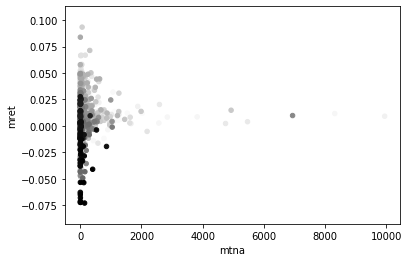

In [17]:
avg_groupby_fund = clean3[['crsp_fundno','mret','mtna']].groupby('crsp_fundno').mean()
avg_groupby_fund.plot.scatter(x='mtna',y='mret',c=avg_groupby_fund.index)

## Histogram

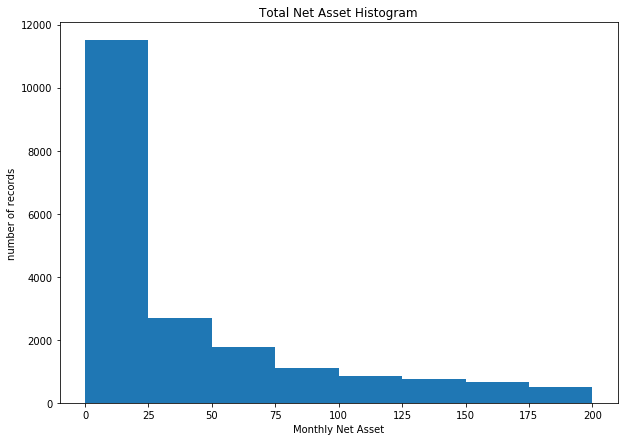

In [18]:
from matplotlib import pyplot as plt
import numpy as np
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(clean3['mtna'], bins = [0, 25, 50, 75, 100, 125,150,175,200])
ax.set_ylabel('number of records')
ax.set_xlabel('Monthly Net Asset')
ax.set_title("Total Net Asset Histogram")
# Show plot
plt.show()

## Barplot for three classes
(Equal number of data points in each bin )

In [19]:
len(clean3)

25732

In [20]:
# 3 bins
ret1 = clean3.sort_values(by='mtna')[:8833]['mret'].mean()
ret2 = clean3.sort_values(by='mtna')[8833:17667]['mret'].mean()
ret3 = clean3.sort_values(by='mtna')[17667:]['mret'].mean()
print(ret1, ret2, ret3)

0.008010528680812715 0.008690078971692246 0.009342383866870264


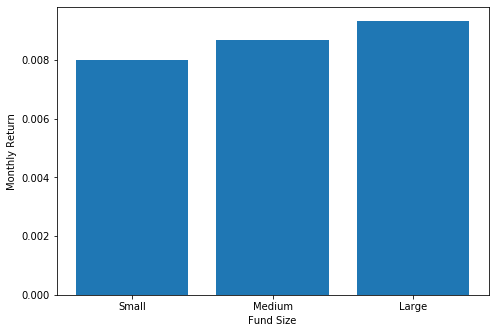

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = ['Small', 'Medium', 'Large']
mret = [ret1, ret2, ret3]
ax.bar(size,mret)
ax.set_ylabel('Monthly Return')
ax.set_xlabel('Fund Size')
plt.show()

In [22]:
import statistics
import math

# annualized return
print('Annualized returns')
print('Small: %.6f'   % ((1+ret1)**12-1))
print('Medium: %.6f'  % ((1+ret2)**12-1))
print('Large: %.6f'   % ((1+ret3)**12-1))

# annualized standard deviation
sd1 = statistics.stdev(clean3['mret'][:8833])*math.sqrt(12)
sd2 = statistics.stdev(clean3['mret'][8833:17667])*math.sqrt(12)
sd3 = statistics.stdev(clean3['mret'][17667:])*math.sqrt(12)

print('\n\nAnnualized standard deviation')
print('Small: %.6f'  % sd1)
print('Medium: %.6f' % sd2)
print('Large: %.6f'  % sd3)

# Sharpe Ratios
print('\n\nSharpe Ratio')
rf=.01
print('Small: %.6f'% ((((1+ret1)**12-1)-rf)/sd1))
print('Medium: %.6f'% ((((1+ret2)**12-1)-rf)/sd2))
print('Large: %.6f'% ((((1+ret3)**12-1)-rf)/sd3))

Annualized returns
Small: 0.100477
Medium: 0.109412
Large: 0.118052


Annualized standard deviation
Small: 0.184450
Medium: 0.214378
Large: 0.218450


Sharpe Ratio
Small: 0.490522
Medium: 0.463726
Large: 0.494632


## Barplot for ten classes
(Equal number of data points in each bin )

In [23]:
n = 2573
ret = []
for i in range(0,10):
    ret.append(clean3.sort_values(by='mtna')[(i*n):((i+1)*n)]['mret'].mean())
ret

[0.006912531913623689,
 0.009979873559973597,
 0.007004984731600594,
 0.008885513427133935,
 0.0072457709995200036,
 0.009456956242450566,
 0.008801255421745756,
 0.009992432370188743,
 0.008869164952596315,
 0.009494201660972276]

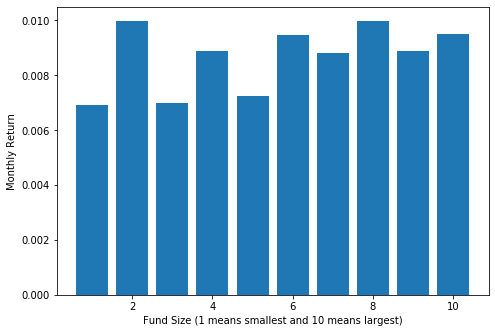

In [24]:
# 10 bins. Each bin has 1/10 of the total amount of data entries, sorted by 'mtna'
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = list(range(1,11))
ax.bar(size,ret)
ax.set_ylabel('Monthly Return')
ax.set_xlabel('Fund Size (1 means smallest and 10 means largest)')
plt.show()

## Barplot for more classes
(As 'mtna' is heavily skewed, we try another way to build each bin with equal threshold)

In [25]:
# THRESHOLDING FUNCTION TO GET BINS

def mtna_threshold(arg):
    temp = 0
    threshold_step = 1000 # needs to be changed
    threshold = 0
    while True:
        if arg < threshold:
            bin = temp
            break
        else:
            threshold += threshold_step
            temp += 1
    return bin

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


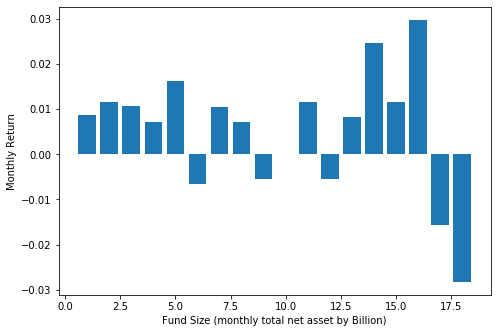

In [26]:
clean3['bin'] = clean3['mtna'].map(mtna_threshold)
new_clean3 = clean3.groupby(['bin']).agg('mean')
new_clean3.reset_index(level=0, inplace=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = list(range(1,11))
ax.bar(new_clean3['bin'],new_clean3['mret'])
ax.set_ylabel('Monthly Return')
ax.set_xlabel('Fund Size (monthly total net asset by Billion)')
plt.show()
